In [75]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.gridspec import GridSpec
from scipy.special import boxcox1p
import warnings

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pandas as pd 
import numpy as np 
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


from sklearn.compose import make_column_transformer
from itertools import combinations 

from scipy import stats
from scipy.stats import norm, kurtosis, skew


from house_utils import data_summary, features_profile, plot_feats


# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from scipy.special import boxcox1p
from patsy import dmatrices

from sklearn.model_selection import StratifiedKFold

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.pipeline import make_pipeline

warnings.filterwarnings("ignore") # ignoring annoying warnings

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1) 
pd.set_option("display.max_rows", 500)

from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV 

###TO PREVENT SCROLLING : SHIFT + O

In [76]:
#I. DATA PREPARATION

In [77]:
# 1. READ THE WHOLE DATASET:
# We load and read the whole dataset (train + test) because we need to clean and preprocess all of it!!!!
#All the procedures must be applied to the entire dataset before split it!

#Step 1: Load train and test sets

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

#Target
target = "Loan_Status"

#Change target type
dict = {"Y":1, "N":0}
train[target] = train[target].map(dict)

#Remove Loan_ID

train.drop("Loan_ID", axis = 1, inplace = True)
test.drop("Loan_ID", axis = 1, inplace = True)


In [78]:
train.shape, test.shape


((614, 12), (367, 11))

In [79]:
#2. Check for duplicates
train.duplicated().sum(), test.duplicated().sum()

(0, 1)

In [80]:
#3. Separate datatypes
categorical = train.select_dtypes(["object", "bool"])
numerical = train.select_dtypes(["float", "int"])

In [81]:
#4. Initial data cleaning
"""Examples of things to consider...
• Are there categorical columns that should be numerical?
• Is the data in the first few rows consistent with the name of the feature?
• Are there lists or dictionaries packed into one feature?
• Are dates in the date data type?"""

'Examples of things to consider...\n• Are there categorical columns that should be numerical?\n• Is the data in the first few rows consistent with the name of the feature?\n• Are there lists or dictionaries packed into one feature?\n• Are dates in the date data type?'

In [82]:
#Changing some datatypes:
#Credit_History should be categorical
#Update for train and test
#train["Credit_History"] = train["Credit_History"].astype("object")
#test["Credit_History"] = test["Credit_History"].astype("object")

#Re-separate columns
categorical = train.select_dtypes(["object", "bool"])
numerical = train.select_dtypes(["float", "int"])

In [83]:
#Separate columns for nominal, ordinal and numerical features for analysis
nominal = ['Loan_ID', 'Gender', 'Married', 'Self_Employed' ]
ordinal = ["Dependents", 'Education','Property_Area']
num = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History']

nominal.remove("Loan_ID")


In [84]:
#II. EXPLORATORY DATA ANALYSIS
#Utils
def bar_plot_feat(data, cols): #bar plot of features
    for col in cols:
        data[col].value_counts(normalize = True).plot.bar(figsize = (7,4), title = col)
        plt.show()
        
def distplot_feat(data, cols):
    for col in cols:
        sns.distplot(data[col])
        plt.show()
        data[col].plot.box(figsize=(10,4))
        plt.show()
        
        
def bivariate(data, cols, target):
    for col in cols:
        df=pd.crosstab(data[col],data[target])
        df.div(df.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True,figsize=(6,6))
        plt.show()


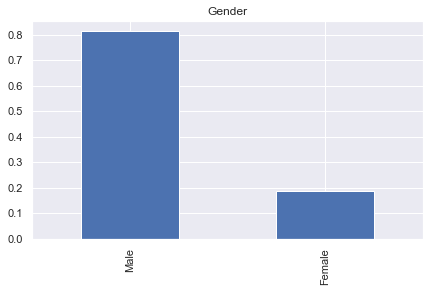

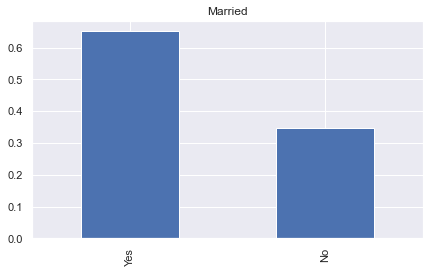

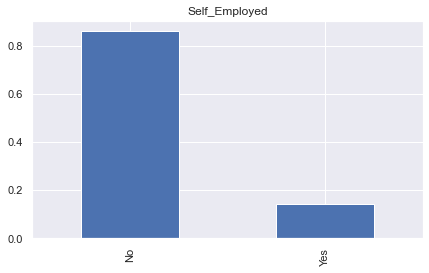

In [85]:
#II. 1 Univariate analysis for checking the dstribution
#Nominal features
#Train set
bar_plot_feat(train,nominal)

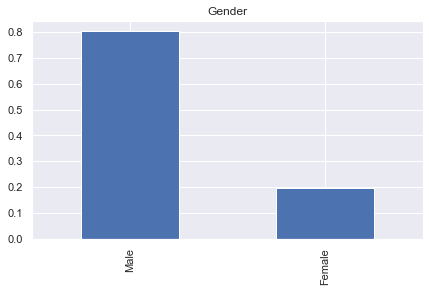

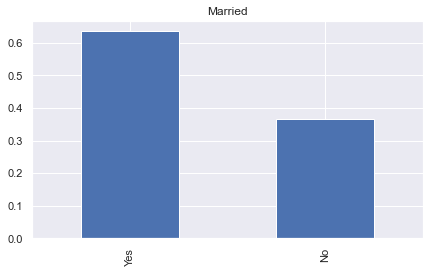

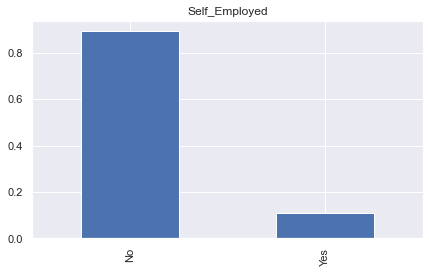

In [86]:
#Test set
bar_plot_feat(test,nominal)

In [87]:
#Observations on nominal data
#Both in train and test sets we see data contains a majority of: men, married, credit history of payment,
#and not self-employees 

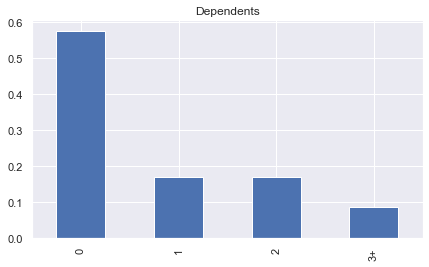

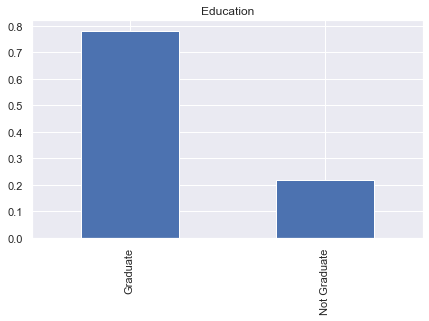

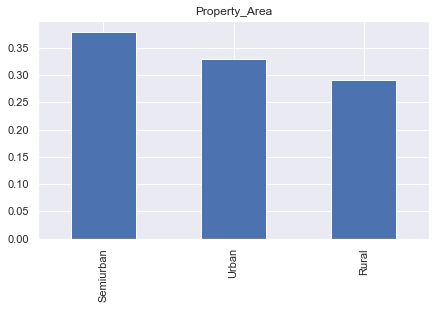

In [88]:
#Ordinal features
#Train set
bar_plot_feat(train,ordinal)

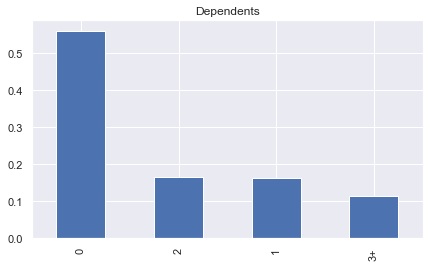

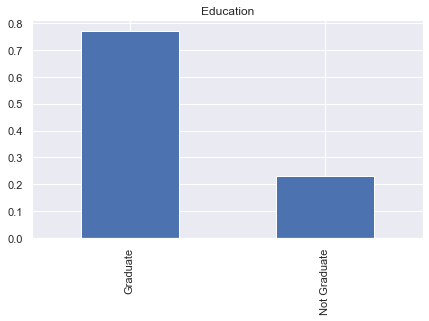

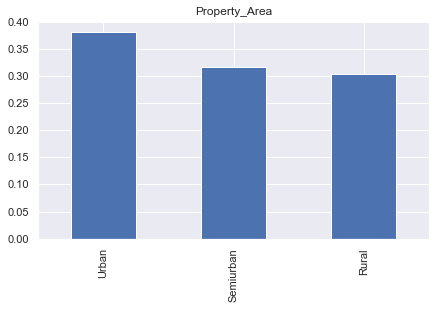

In [89]:
#Test set
bar_plot_feat(test,ordinal)

In [90]:
#Observations on nominals
#Both in train and test sets we see data contains a majority of: graduates with 0 dependents, and more 
#than 65% are applyying for urban or semi urban property_areas

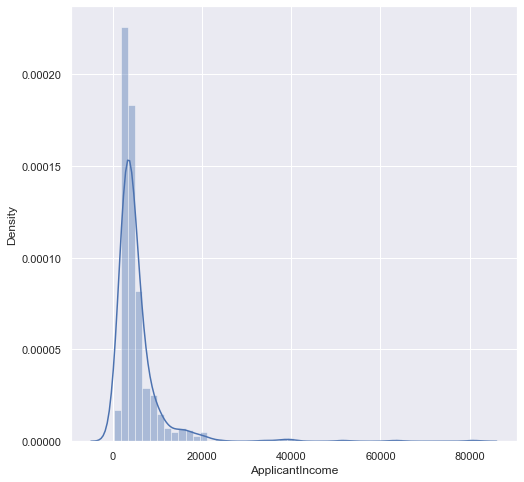

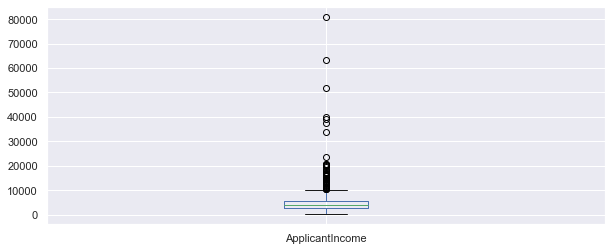

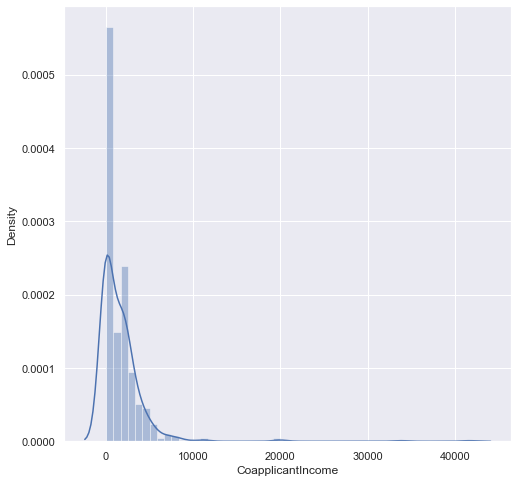

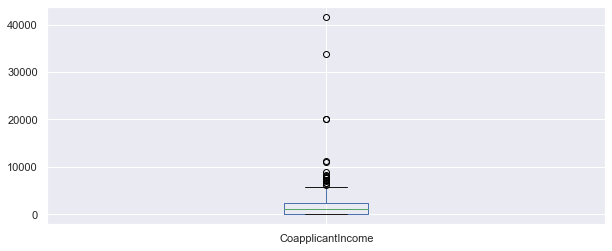

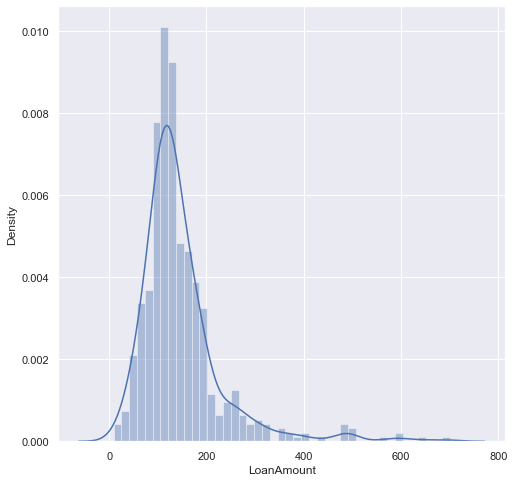

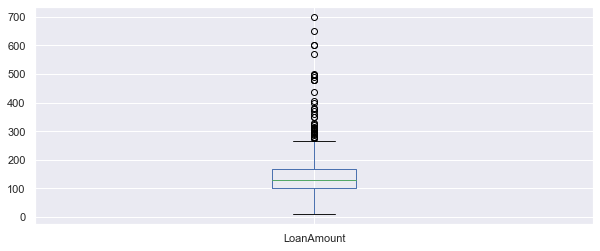

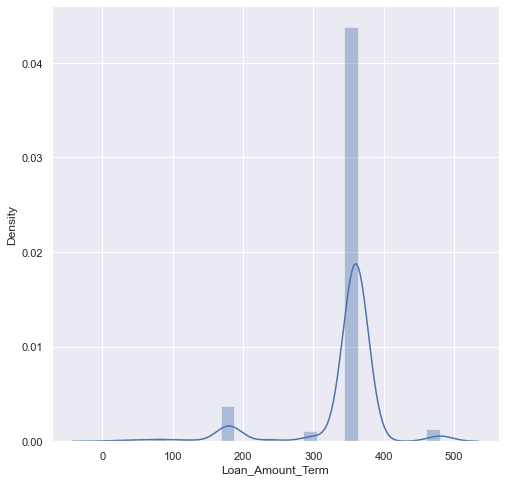

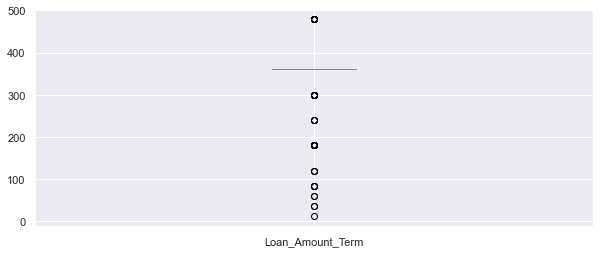

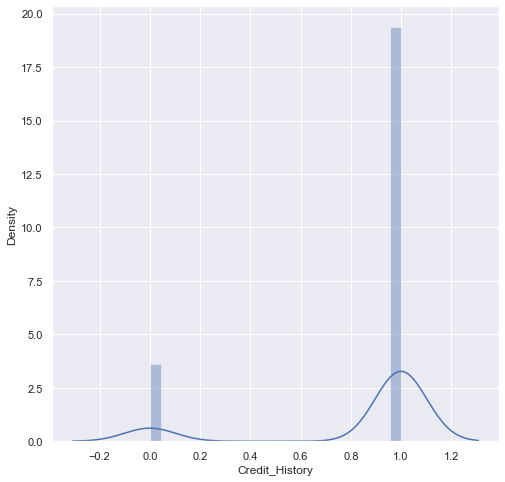

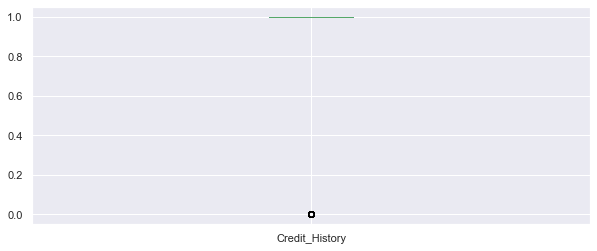

In [91]:
#Numerical features
#train test
distplot_feat(train, num)

In [92]:
#Describe
train[num].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.0000,614.0000,592.0000,600.0000,564.0000
mean,5403.4593,1621.2458,146.4122,342.0000,0.8422
std,6109.0417,2926.2484,85.5873,65.1204,0.3649
min,150.0000,0.0000,9.0000,12.0000,0.0000
25%,2877.5000,0.0000,100.0000,360.0000,1.0000
50%,3812.5000,1188.5000,128.0000,360.0000,1.0000
75%,5795.0000,2297.2500,168.0000,360.0000,1.0000
max,81000.0000,41667.0000,700.0000,480.0000,1.0000


In [93]:
#Observaciones:
#ApplicantIncome: right skewed, presence of outliers, central tendency measure is median, no modal/bimodal, no subpopulations
#CoapplicantIncome: right skewed, presence of outliers, central tendency measure is median, no modal/bimodal, no subpopulations
#LoanAmount: right skewed, presence of outliers, central tendency measure is median, no modal/bimodal, no subpopulations
#Loan_Amount_Term: left skewed, no presence of outliers, central tendency measure is median, no modal/bimodal, no subpopulations

In [94]:
##General observations summary:
#Both in train and test sets we see data contains a majority of: graduates with 0 dependents, and more 
#than 65% are applyying for urban or semi urban property_areas
#Both in train and test sets we see data contains a majority of: men, married, credit history of payment,
#and not self-employees 

#Get the medians of num for analysis:
for c in num:
    print(c, ":", train[c].median())

ApplicantIncome : 3812.5
CoapplicantIncome : 1188.5
LoanAmount : 128.0
Loan_Amount_Term : 360.0
Credit_History : 1.0


In [95]:
#TEST TAKING A SUBSET OF THE MOST COMMON CHARACTERISTICS IN DATASET AND SEE ITS TARGET DISTRIBUTION
filter = train[(train.Gender == "Male") & (train.Dependents == "0") & (train.Property_Area == "Urban") &
              (train.Education == "Graduate") & (train.Married == "Yes") & (train.Credit_History == 1)]

In [96]:
#Son pocos pero todos obtienen aprobacion
filter.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
2,Male,Yes,0,Graduate,Yes,3000,0.0000,66.0000,360.0000,1.0000,Urban,1
19,Male,Yes,0,Graduate,NaN,2600,3500.0000,115.0000,nan,1.0000,Urban,1
35,Male,Yes,0,Graduate,No,2275,2067.0000,nan,360.0000,1.0000,Urban,1
47,Male,Yes,0,Graduate,No,5821,0.0000,144.0000,360.0000,1.0000,Urban,1
60,Male,Yes,0,Graduate,No,2500,3796.0000,120.0000,360.0000,1.0000,Urban,1


In [97]:
#II.2 Bivariate Analysis
nominal

['Gender', 'Married', 'Self_Employed']

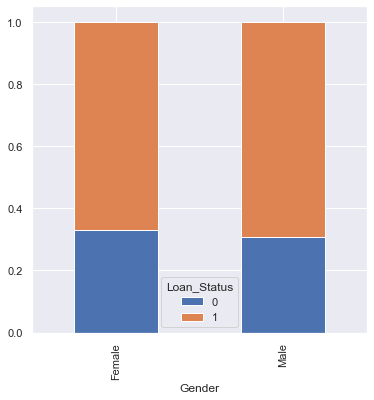

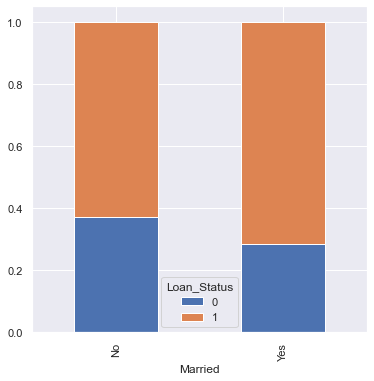

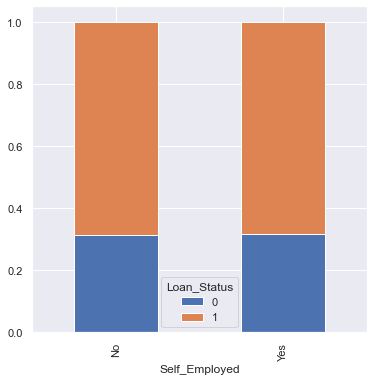

In [98]:
bivariate(train, nominal, "Loan_Status")

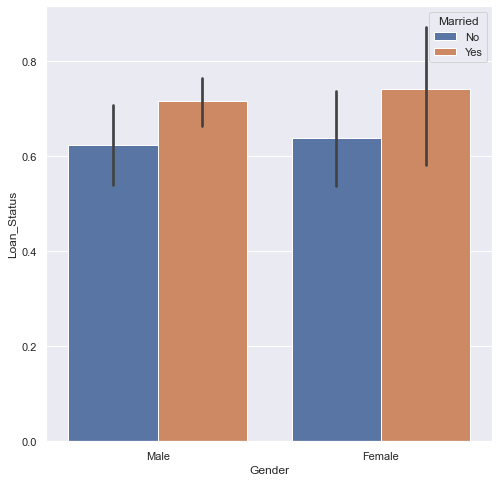

In [99]:
#Second layer: analysis of combined features

#Is there a difference in gender/married concerning loans?

#Updated insights:
#Married people have higher chances of getting the loan
#Married women have higher chances of getting a loan (the highest)
#(crear new feat Gender_Married)

ax = sns.barplot(x="Gender", y= target, hue = "Married", data=train)

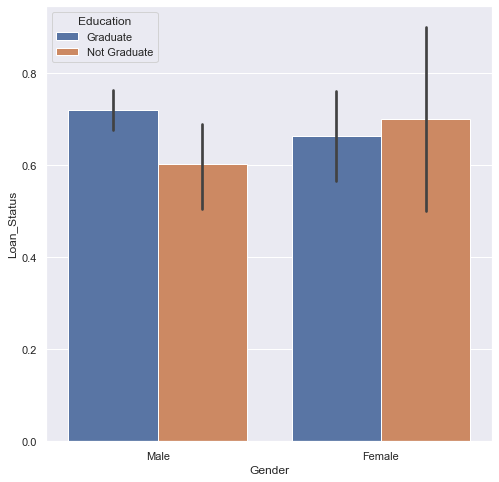

In [100]:
#Gender and Education
ax = sns.barplot(x="Gender", y= target, hue = "Education", data=train)

#Updated:
#Graduated men have higher chances of loan than non graduated
#NON-graduated women have higher chances than graduated women
#Graduated men have more chances of a loan than graduated women
#NON graduated women have more chances of loan that NON graduated men
#(new feature: Gender_Education)

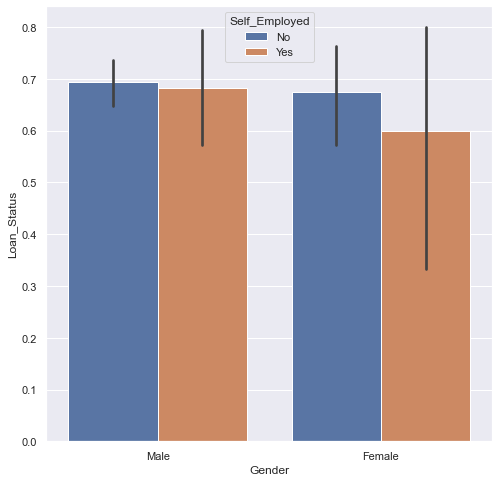

In [101]:
#Gender and Self_Employed
ax = sns.barplot(x="Gender", y= target, hue = "Self_Employed", data=train)
#Update:
#No self employed have higher chances of a loan
#No self employed women have higher chances than self-employed women
#(new feature: Gender_Self_Employed)

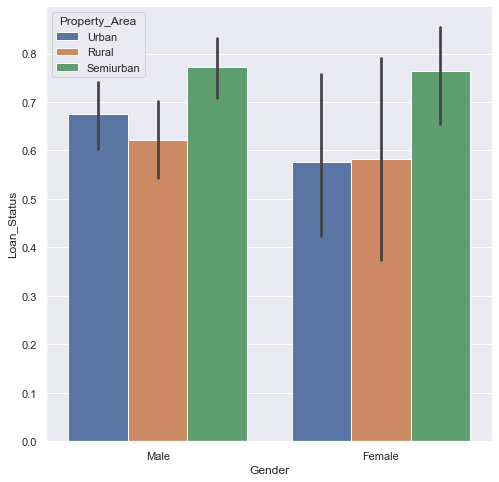

In [102]:
#Gender and Property_Area
ax = sns.barplot(x="Gender", y= target, hue = "Property_Area", data=train)

#Update:
#People applying for semiurban have the highest chances of a loan, men and women
#(new feature: Gender_Property_Area)

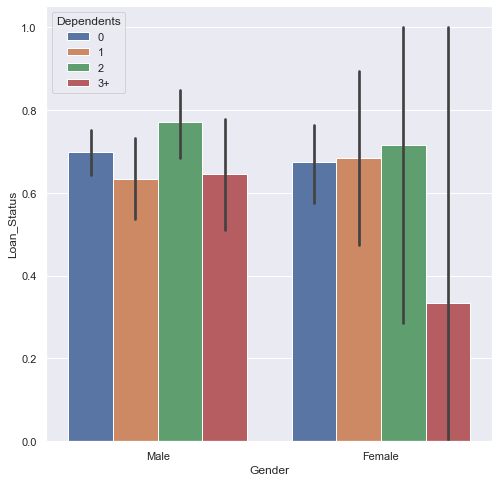

In [103]:
#Gender and Dependents
ax = sns.barplot(x="Gender", y= target, hue = "Dependents", data=train)

#Women with 3+ dependents have the lowes chances, half of men´s in the same situation
#Men with 2 dependents have higher chances than women with 2 dependends
#Men with 0 dependents have highee chances than women with 0 dependents
#In general, women with dependents have lower chances than men with dependents
#(new feature: Gender_Dependents)


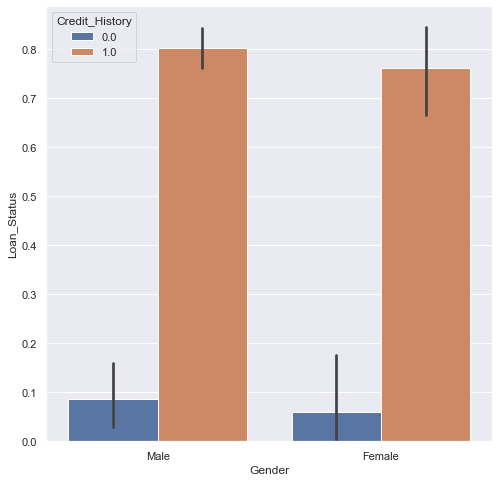

In [104]:
#Gender and Credit_History
ax = sns.barplot(x="Gender", y= target, hue = "Credit_History", data=train)
#Importance of credit history confirmed

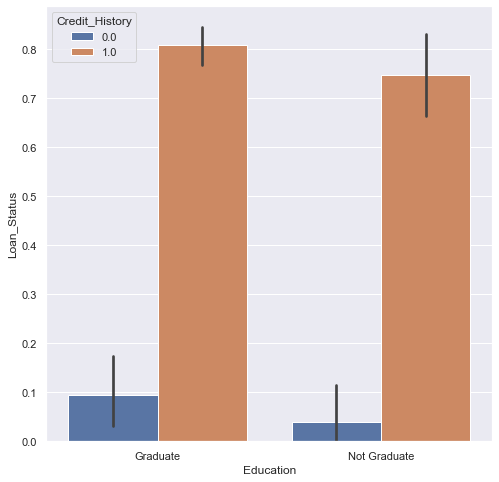

In [105]:
#Education and credit history
ax = sns.barplot(x="Education", y= target, hue = "Credit_History", data=train)

#Just confirms importance of history in both cases



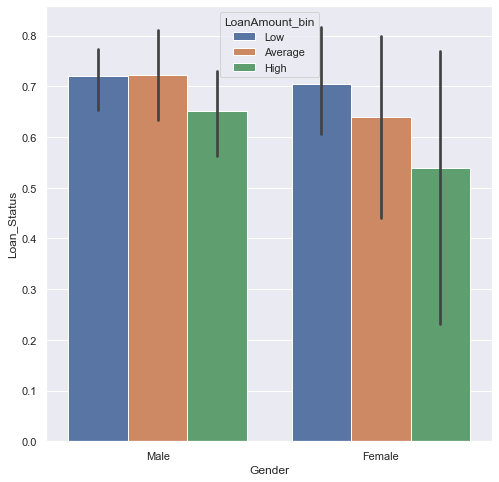

In [106]:
#Loan amount and Gender
#We must bin the feature first
t = train.copy()
bins=[0,130,170, 700]
group=["Low","Average","High"]
t["LoanAmount_bin"]=pd.cut(t["LoanAmount"],bins,labels=group)

ax = sns.barplot(x="Gender", y= target, hue = "LoanAmount_bin", data= t)

#Men have higher chances of getting high amount loans than women
##Men have higher chances of getting average amount loans than women
#(new feature: Gender_LoanAmount_bin)




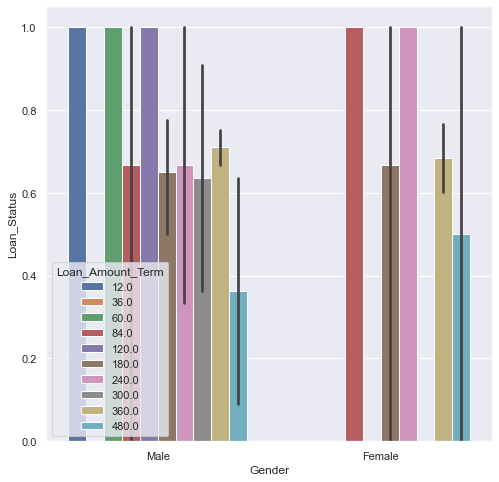

In [107]:
#Gender and term
ax = sns.barplot(x="Gender", y= target, hue = "Loan_Amount_Term", data= train)
#Update:
#Several differences in gender for loan terms
#Women hab higher chances of getting a long term loan than men
#(new feature: Gender_Loan_Amount_Term)


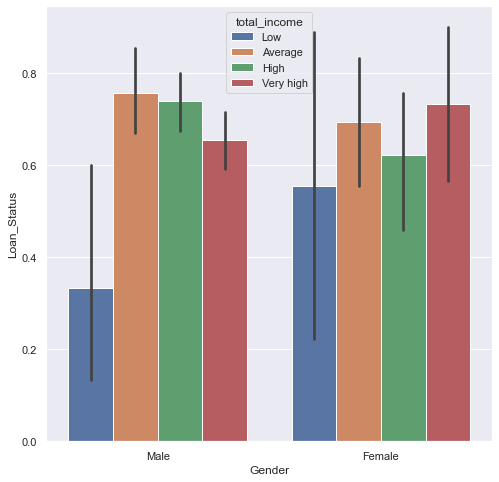

In [108]:
#Gender and CoapplicantIncome + ApplicantINcome
t = train.copy()
t["total_income"] = t["ApplicantIncome"] + t["CoapplicantIncome"]
bins=[0,2500,4000,6000,81000]
group=["Low","Average","High","Very high"]

t["total_income"]=pd.cut(t["total_income"],bins,labels=group)
ax = sns.barplot(x="Gender", y= target, hue = "total_income", data= t)

#Update:
#women with very high total income have more chances of gettin a loan than men with hig total income
#Men with average and high have more chances than women with average and high
#Women with low total income have more chances than men with low total income
#new feature: Gender_total_income)


In [109]:
numerical.columns

Index(['CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',
       'Credit_History'],
      dtype='object')

In [110]:
#Observ:

#Genero no influye en otorgamiento del credito
#Married applicants have more chances to get a loan
#Self employed is irrelevant
#80% of people with good history get the loan, while 90% of those with no record dont get it ***

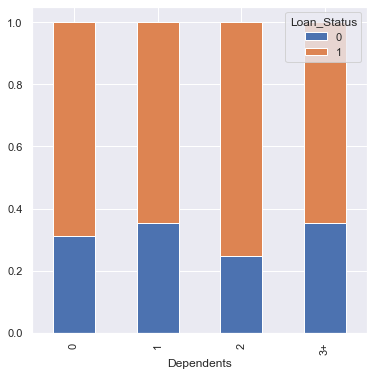

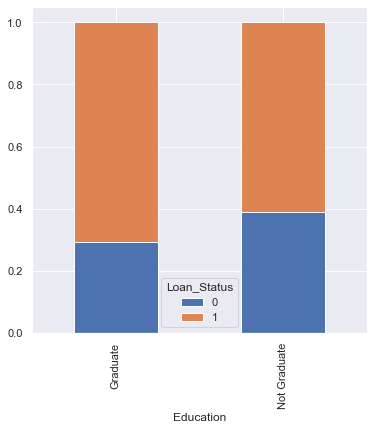

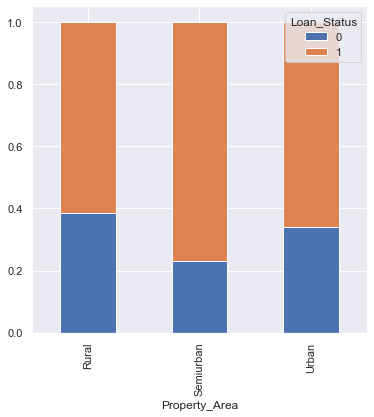

In [111]:
#Ordinal
bivariate(train, ordinal, "Loan_Status")

In [112]:
#Dependants 2 and 0 have the highest chance of getting the loan
#Graduates have higher chance (70% versus 60%)
#Semiurban Property_Area have the highest chance (80%)

In [113]:
#Numerical
#Dado que son valores dispersos y continuos, se binea pero solo para el analisis

In [114]:
train[num].describe(include = "all")

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.0000,614.0000,592.0000,600.0000,564.0000
mean,5403.4593,1621.2458,146.4122,342.0000,0.8422
std,6109.0417,2926.2484,85.5873,65.1204,0.3649
min,150.0000,0.0000,9.0000,12.0000,0.0000
25%,2877.5000,0.0000,100.0000,360.0000,1.0000
50%,3812.5000,1188.5000,128.0000,360.0000,1.0000
75%,5795.0000,2297.2500,168.0000,360.0000,1.0000
max,81000.0000,41667.0000,700.0000,480.0000,1.0000


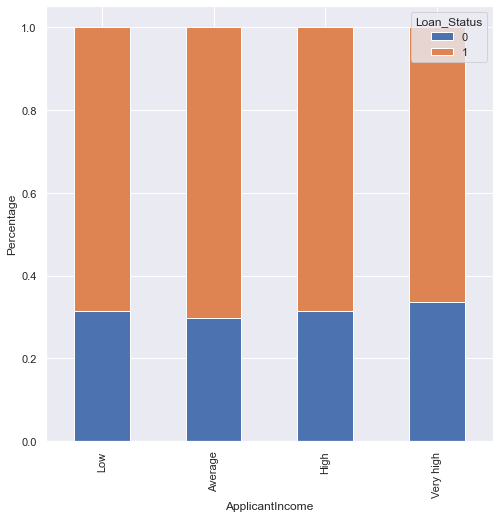

In [115]:
#ApplicantIncome
bins=[0,2500,4000,6000,81000]
group=["Low","Average","High","Very high"]
train["Income_bin"]=pd.cut(train["ApplicantIncome"],bins,labels=group)
Income_bin=pd.crosstab(train["Income_bin"],train["Loan_Status"])
Income_bin.div(Income_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.xlabel("ApplicantIncome")
P=plt.ylabel("Percentage")

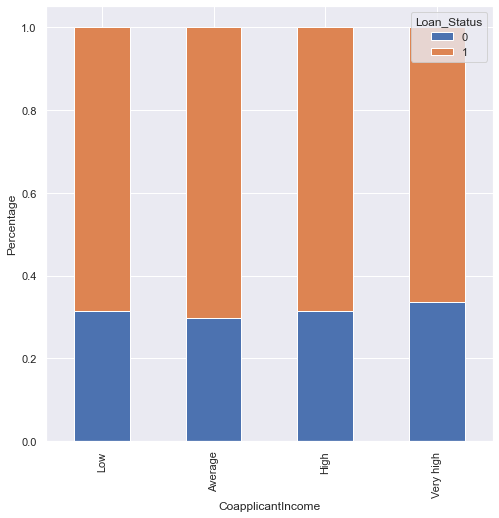

In [116]:
#CoapplicantIncome
bins=[0,1200,2300,42000]
group=["Low","Average","High"]
train["Coapplicant_Income_bin"]=pd.cut(train["CoapplicantIncome"],bins,labels=group)
Income_bin=pd.crosstab(train["Income_bin"],train["Loan_Status"])
Income_bin.div(Income_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.xlabel("CoapplicantIncome")
P=plt.ylabel("Percentage")

In [117]:
#Se ve que cuando el ingreso del coapplicant es el mas bajo es cuando mayor probabilidad hay de loan, nosense
#Hay valores 0 de coapplicant, por lo que puede que se trata de que no hay coapplicant.
#Creo un nuevo feat que suma los ingresos y analizo
train["total_income"] = train["ApplicantIncome"] + train["CoapplicantIncome"]


#CoapplicantIncome
#ApplicantIncome
train["total_income"].describe()

count   614.0000  
mean    7024.7051 
std     6458.6639 
min     1442.0000 
25%     4166.0000 
50%     5416.5000 
75%     7521.7500 
max     81000.0000
Name: total_income, dtype: float64

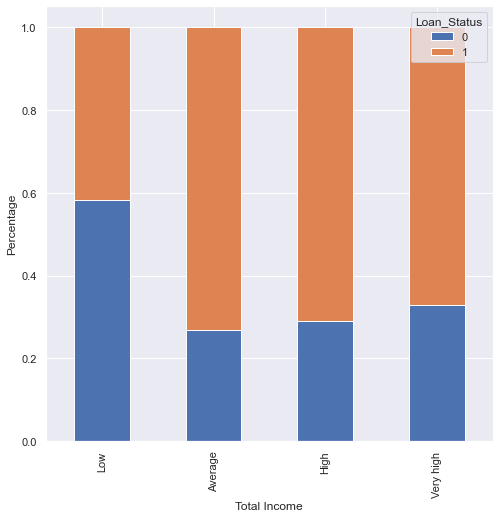

In [118]:
#bins=[0,4200,5500,7600,81000]
bins=[0,2500,4000,6000,81000]
group=["Low","Average","High","Very high"]
train["total_income"]=pd.cut(train["total_income"],bins,labels=group)
Income_bin=pd.crosstab(train["total_income"],train["Loan_Status"])
Income_bin.div(Income_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.xlabel("Total Income")
P=plt.ylabel("Percentage")

In [119]:
#Those with LOW income class have LESS chances of getting the loan (60%)

In [120]:
train.LoanAmount.describe()

count   592.0000
mean    146.4122
std     85.5873 
min     9.0000  
25%     100.0000
50%     128.0000
75%     168.0000
max     700.0000
Name: LoanAmount, dtype: float64

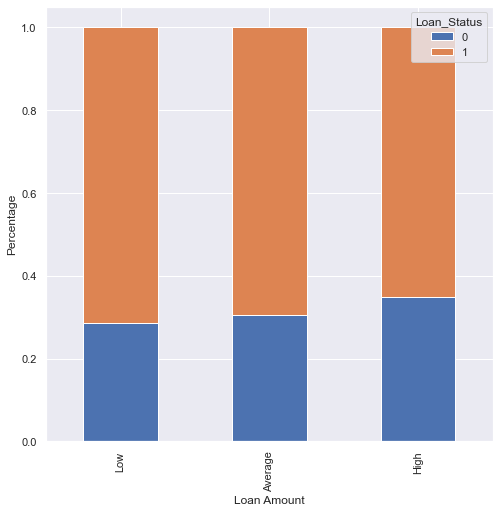

In [121]:
#LoanAmount
bins=[0,130,170, 700]
group=["Low","Average","High"]
train["LoanAmount_bin"]=pd.cut(train["LoanAmount"],bins,labels=group)
Income_bin=pd.crosstab(train["LoanAmount_bin"],train["Loan_Status"])
Income_bin.div(Income_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.xlabel("Loan Amount")
P=plt.ylabel("Percentage")


In [122]:
#Se ve que para los low and average  loan amounts hay mas chance de tener el loan

In [123]:
train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'Income_bin', 'Coapplicant_Income_bin', 'total_income',
       'LoanAmount_bin'],
      dtype='object')

In [124]:
#Drop the created bin columns, bacause they were for analysis only
train.drop(['Income_bin', 'Coapplicant_Income_bin', 'total_income','LoanAmount_bin', 
            "total_income"], axis = 1, inplace = True)


In [125]:
#Replace +3 in Dependants by 3

train["Dependents"].replace("3+", "3",inplace=True)
test["Dependents"].replace("3+", "3",inplace=True)



In [126]:
##Summary of observations from EDA:

#Both in train and test sets we see data contains a majority of: graduates with 0 dependents, and more 
#than 65% are applyying for urban or semi urban property_areas
#Both in train and test sets we see data contains a majority of: men, married, credit history of payment,
#and not self-employees 

#Genero no influye en otorgamiento del credito
#Married applicants have more chances to get a loan
#Self employed is irrelevant
#80% of people with good history get the loan, while 90% of those with no record dont get it ***

#Dependants 2 and 0 have the highest chance of getting the loan
#Graduates have higher chance (70% versus 60%)
#Semiurban Property_Area have the highest chance (80%)

#Loan is indifferent to applicantincome
#Those with LOW income class have LESS chances of getting the loan (60%)
#Se ve que para los low and average  loan amounts hay mas chance de tener el loan


#Most relevant features: Credit_History, loan_amount, Semiurban Property_Area, education graduated, dependents 2 and 0, married

#Irrelevan: Genre, self employed, ApplicantIncome




<AxesSubplot:>

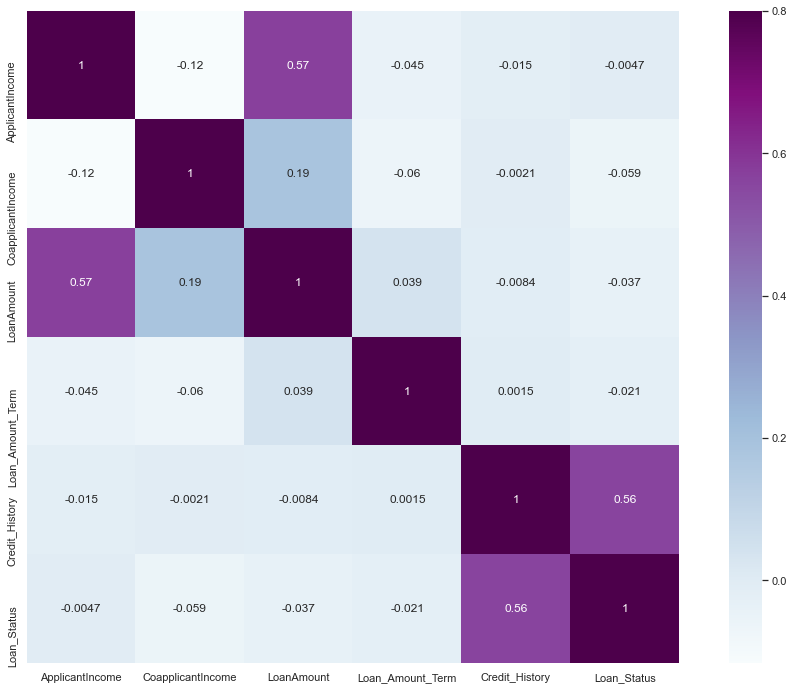

In [127]:
#II.3 PRELIMINAR CORRELATION ANALYSIS
matrix = train.corr()
f, ax = plt.subplots(figsize = (18,12))
sns.heatmap(matrix, vmax = 0.8, square = True, cmap = "BuPu", annot = True)

In [128]:
#The highest correlation is between LOanAmount and Applicant Income
#The highest correlation with target is Credit History

#Observation: el otorgamiento de prestamo depende en gran medida del credit hstory, y de los ingresos del aval
#y el monto a prestar en segundo y tercer termino

In [129]:
#II.MISSING VALUES ASSESSMENT
#Train 
null_counts = train.isnull().sum()
null_counts[null_counts > 0]

#Policy for nulls treatment
#For both num and categ will use the most frequent value of each class in the dataset
nulls_num_train = ["LoanAmount", "Loan_Amount_Term", "Credit_History"]
nulls_cat_train = ["Married", "Dependents", "Self_Employed", "Gender"]

#Nulls imputation

def median_target(df, var):   
    temp = df[df[var].notnull()]
    temp = temp[[var, target]].groupby([target])[[var]].median().reset_index()
    return temp
columns = nulls_num_train
for i in columns:
    median_target(train, i)
    train.loc[(train[target] == 0 ) & (train[i].isnull()), i] = median_target(train, i)[i][0]
    train.loc[(train[target] == 1 ) & (train[i].isnull()), i] = median_target(train, i)[i][1]
    
def cat_impute(df, cols):
    for col in cols:
        mode_1 = df.loc[(df[target] == 1), col].mode()[0]
        mode_0 = df.loc[(df[target] == 0), col].mode()[0]
        df.loc[(df[target] == 1) & (df[col].isnull()), col] = mode_1
        df.loc[(df[target] == 0) & (df[col].isnull()), col] = mode_0 

cat_impute(train, nulls_cat_train)


In [130]:
#test set
null_counts = test.isnull().sum()
null_counts[null_counts > 0]

Gender              11
Dependents          10
Self_Employed       23
LoanAmount          5 
Loan_Amount_Term    6 
Credit_History      29
dtype: int64

In [131]:
##Policy for nulls treatment
#For both num and categ will use the most frequent value of each class in the dataset
nulls_num_test = ["LoanAmount", "Loan_Amount_Term", "Credit_History"]
nulls_cat_test = [ "Dependents", "Self_Employed", "Gender"]

def impute_test(df, colsNum, colsCat):
    for col in colsNum:
        df.loc[df[col].isnull(), col] = df[col].median()
    for col in colsCat:
        df.loc[df[col].isnull(), col] = df[col].mode()[0]

In [132]:
impute_test(test, nulls_num_test, nulls_cat_test)

In [133]:
test.isnull().sum().sum()

0

In [134]:
#III. FEATURE ENGINEERING
""""Some ideas
• Aggregations (across groups or dates)
• Ratios (divide)
• Interactions (multiply)
• Frequency (counts)
• Pull parts from dates (months/days/hours)"""

'"Some ideas\n• Aggregations (across groups or dates)\n• Ratios (divide)\n• Interactions (multiply)\n• Frequency (counts)\n• Pull parts from dates (months/days/hours)'

In [135]:
#IV. DATA TRANSFORMATION
""""Transform Data
• Numerical
      - Normalize or Standardize
      - Log-transform
      - Remove outliers
• Categorical
      - One-hot encode (nominal)
      - Label encoder (ordinal)
      - Binarize (binary)
• Text
      - Tokenize
      - Stem/Lemma
      - TF-IDF
      - (and much more NLP techniques)"""

'"Transform Data\n• Numerical\n      - Normalize or Standardize\n      - Log-transform\n      - Remove outliers\n• Categorical\n      - One-hot encode (nominal)\n      - Label encoder (ordinal)\n      - Binarize (binary)\n• Text\n      - Tokenize\n      - Stem/Lemma\n      - TF-IDF\n      - (and much more NLP techniques)'

In [136]:
#Data transformation
#NUMERICAL FEATURES TRANSFORMATIONS

#TREATMENT OF SKEWED NUMERICAL FEATURES
def feat_transform(all_data):
    cols = all_data.columns
    #Seleccionamos los numeric features only (usamos cols porque esos son los feats que quedaron)
#     numeric_features = all_data.loc[:, list(cols)].dtypes[(all_data.dtypes != "category") & (all_data.dtypes != "uint8")].index
    numeric_features = num
    print(numeric_features)
    # #Calculamos los skewes y los ordenamos...
    skewed_features = all_data[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending =False)

    #Seleccionamos los que tengan un abs(skew) >0.7
    skewed_max = pd.DataFrame({"Skew": skewed_features})
    skewed_max  = skewed_max[abs(skewed_max["Skew"]) > 0.7]
    skewed_max.dropna()

    #Aplicamos ahora la BoxCox transformation
    l_opt = {}
    for f in skewed_max.index:
        all_data[f], l_opt[f] = boxcox((all_data[f] + 1))

    #Checking the results...

    skewed_features_2 = all_data[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending =False)
    sk_2 = pd.DataFrame({"Skew_before":skewed_features, "Skew_after": skewed_features_2})
    sk_2 = sk_2[abs(sk_2["Skew_before"]) > 0.7].sort_values(by = "Skew_before", ascending = False)
    print(sk_2)
    
    return all_data

In [137]:
#Train set 

data_summary(df = train.select_dtypes(include = "number"), target = target)

,Dtype,Uniques,Nulls,% Nulls,Skew,Kurtosis,Correlation
Loan_Status,int64,2,0,0.0000,-0.8100,-1.3480,1.0000
Credit_History,float64,2,0,0.0000,-2.0220,2.0950,0.5410
CoapplicantIncome,float64,287,0,0.0000,7.4920,84.9560,-0.0590
LoanAmount,float64,203,0,0.0000,2.7430,10.9360,-0.0340
Loan_Amount_Term,float64,10,0,0.0000,-2.4020,6.9250,-0.0230
ApplicantIncome,int64,505,0,0.0000,6.5400,60.5410,-0.0050


In [138]:
 train = feat_transform(train)

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
                   Skew_before  Skew_after
CoapplicantIncome 7.4732       -0.1453    
ApplicantIncome   6.5235       -0.0927    
LoanAmount        2.7365       0.0207     
Credit_History    -2.0170      -2.0170    
Loan_Amount_Term  -2.3962      0.3916     


In [139]:
train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5.7686,0.0000,5.4990,18182061.1055,95.3036,Urban,1
1,Male,Yes,1,Graduate,No,5.6662,9.1493,5.5191,18182061.1055,95.3036,Rural,0
2,Male,Yes,0,Graduate,Yes,5.4821,0.0000,4.6925,18182061.1055,95.3036,Urban,1
3,Male,Yes,0,Not Graduate,No,5.4152,9.8459,5.4370,18182061.1055,95.3036,Urban,1
4,Male,No,0,Graduate,No,5.7792,0.0000,5.6426,18182061.1055,95.3036,Urban,1


In [140]:
data_summary(df = train.select_dtypes(include = "number"), target = target)

,Dtype,Uniques,Nulls,% Nulls,Skew,Kurtosis,Correlation
Loan_Status,int64,2,0,0.0000,-0.8100,-1.3480,1.0000
Credit_History,float64,2,0,0.0000,-2.0220,2.0950,0.5410
CoapplicantIncome,float64,287,0,0.0000,-0.1460,-1.8780,0.0570
Loan_Amount_Term,float64,10,0,0.0000,0.3930,7.0780,-0.0540
LoanAmount,float64,203,0,0.0000,0.0210,2.4540,-0.0390
ApplicantIncome,float64,505,0,0.0000,-0.0930,4.7710,0.0140


In [141]:
#Test set transformations
for c in test[num].columns:
    print(c, ":", test[c].skew(), test[c].kurt())

ApplicantIncome : 8.441374954190996 103.12748954245407
CoapplicantIncome : 4.257356934477602 30.191142101153826
LoanAmount : 2.244600521260248 9.588774529299508
Loan_Amount_Term : -2.709536758573826 8.866289165749418
Credit_History : -1.8547214446428353 1.4478521776740618


In [142]:
 test = feat_transform( test.select_dtypes(include = "number")) 

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
                   Skew_before  Skew_after
ApplicantIncome   8.4068       0.6540     
CoapplicantIncome 4.2399       -0.2006    
LoanAmount        2.2354       0.0257     
Credit_History    -1.8471      -1.8471    
Loan_Amount_Term  -2.6984      0.3195     


In [143]:
for c in test[num].columns:
    print(c, ":", test[c].skew(), test[c].kurt())

ApplicantIncome : 0.6567091448811212 10.111684303300967
CoapplicantIncome : -0.20145210955025647 -1.8330806862761448
LoanAmount : 0.025822498260956093 1.7383274908348594
Loan_Amount_Term : 0.3208023633380084 7.848178783843158
Credit_History : -1.8547214446428328 1.4478521776740574


In [144]:
#RESCALING OF NUMERICAL FEATURES

#Rescaling train set
train[num].head(7)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,5.7686,0.0000,5.4990,18182061.1055,95.3036
1,5.6662,9.1493,5.5191,18182061.1055,95.3036
2,5.4821,0.0000,4.6925,18182061.1055,95.3036
3,5.4152,9.8459,5.4370,18182061.1055,95.3036
4,5.7792,0.0000,5.6426,18182061.1055,95.3036
5,5.7367,10.7716,6.4750,18182061.1055,95.3036
6,5.3691,9.1575,5.1428,18182061.1055,95.3036


In [145]:
#Rescaling test set
test[num].head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,30.3659,0.0000,6.1965,19094555.6909,52.1735
1,25.4683,10.0596,6.4260,19094555.6909,52.1735
2,29.2389,10.3964,7.3058,19094555.6909,52.1735
3,23.5370,11.0513,6.0376,19094555.6909,52.1735
4,25.9319,0.0000,5.6319,19094555.6909,52.1735


In [146]:
#OneHotEncoder
def ohe_mae(df, target):
        #Selecciona todas las cols excepto target
    if target!= "None":
        df_sel = df.loc[:, df.columns != target]
    else:
        df_sel = df

    cat_feats = df_sel.select_dtypes(include= object).columns
    num_feats = df_sel.select_dtypes(exclude= object).columns

    print(cat_feats)
    # creating instance of one-hot-encoder
    enc = OneHotEncoder(handle_unknown='ignore')
    # passing bridge-types-cat column (label encoded values of bridge_types)
    enc_df = pd.DataFrame(enc.fit_transform(df_sel[cat_feats]).toarray())
    
    print("Number of features onehotencoded:", enc_df.shape[1])
    # Rejoin
    df_sel = df_sel[num_feats].join(enc_df)

    #Get back together with target
    if target!= "None":
        df = pd.concat((df[target], df_sel), axis = 1)
    else:
        df = df_sel

    print("Final shape of all data after OneHotEncoding:", df.shape)

#OHE train set
ohe_mae(train, target)

#OHE test set
ohe_mae(train, target = "None")



Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area'],
      dtype='object')
Number of features onehotencoded: 15
Final shape of all data after OneHotEncoding: (614, 21)
Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area'],
      dtype='object')
Number of features onehotencoded: 15
Final shape of all data after OneHotEncoding: (614, 21)


In [147]:
train["Dependents"].unique()

array(['0', '1', '2', '3'], dtype=object)

In [148]:
###BASELINE TESTING FOR CHECKING FEATURES

#Baseline
dt = DecisionTreeClassifier(random_state = 42)
scl = StandardScaler()
pipeline = make_pipeline(StandardScaler(), dt)
base_cols = list(num) + list(["Loan_Status"])
t = train[base_cols].copy()
y = t.pop(target)
X = t
scoring ="accuracy"
# X = t.drop("Loan_ID", axis =1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

kfold = StratifiedKFold(n_splits= 10) 
cv_results = cross_val_score(estimator = pipeline, X= X_train , y = y_train , scoring = scoring, cv = kfold)
print("Score:", cv_results.mean())
print("Std_Error:", cv_results.std()) 
      

Score: 0.7251020408163266
Std_Error: 0.04548823483647294


In [150]:
lr = LogisticRegression(random_state = 42)
scl = StandardScaler()
pipeline = make_pipeline(StandardScaler(), lr)
base_cols = list(num) + list(["Loan_Status"])
t = train[base_cols].copy()
y = t.pop(target)
X = t
scoring ="accuracy"
# X = t.drop("Loan_ID", axis =1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

kfold = StratifiedKFold(n_splits= 10) 
cv_results = cross_val_score(estimator = pipeline, X= X_train , y = y_train , scoring = scoring, cv = kfold)
print("Score:", cv_results.mean())
print("Std_Error:", cv_results.std())


Score: 0.8147346938775512
Std_Error: 0.046585878385761156
